#**QUERY 1**

+-------+-----+
|   word|count|
+-------+-----+
|    Sam|  243|
|  Frodo|  227|
| Gollum|  180|
|Gandalf|  163|
|   Orcs|  152|
|Aragorn|  111|
+-------+-----+



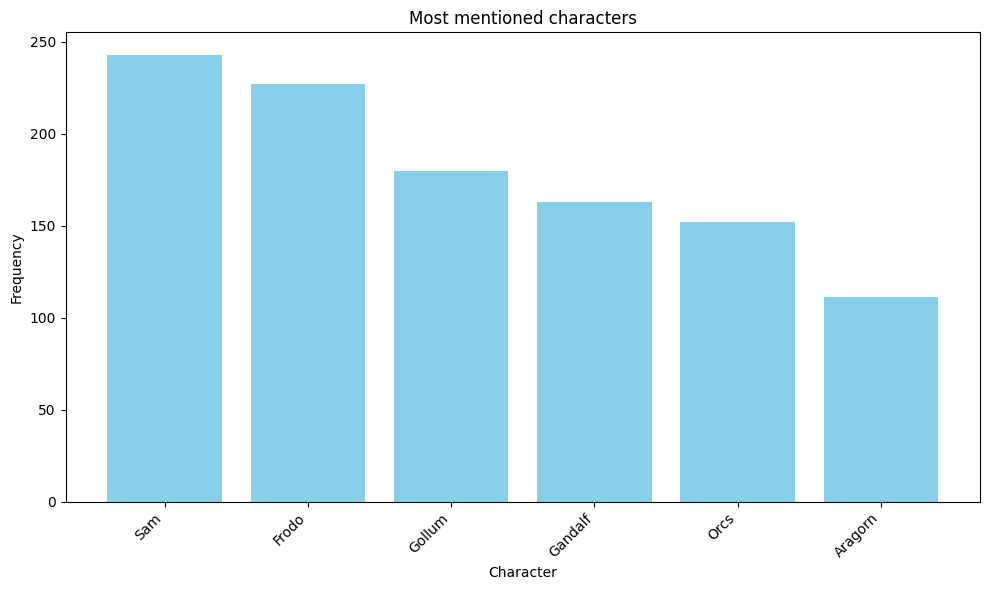

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col
import matplotlib.pyplot as plt

# Create Spark session
spark = SparkSession.builder.appName("Question1").getOrCreate()

# Read the CSV file (make sure the filename matches the uploaded one)
df = spark.read.option("header", True).csv("two_towers_chapters_unique.csv")

# List of stopwords
stopwords = ["The", "He", "His", "She", "It", "They", "You", "Your", "I", "We", "A", "An", "In", "Of", "On", "With", "As", "At", "To", "From", "And", "But", "That", "This", "For", "By", "Not", "So", "Then", "There"]

# Tokenization
tokens = df.select(explode(split(col("text"), r"\s+")).alias("word"))

# Filtering
characters = tokens.filter(
    (col("word").rlike("^[A-Z][a-z]+$")) &
    (~col("word").isin(stopwords))
)

# Grouping and filtering
important_characters = characters.groupBy("word").count().filter("count > 100").orderBy("count", ascending=False)

# Show in console
important_characters.show()

# To plot, we need to bring the data to Pandas
pandas_df = important_characters.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['word'], pandas_df['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.title("Most mentioned characters")
plt.tight_layout()
plt.show()


# **QUERY 2**

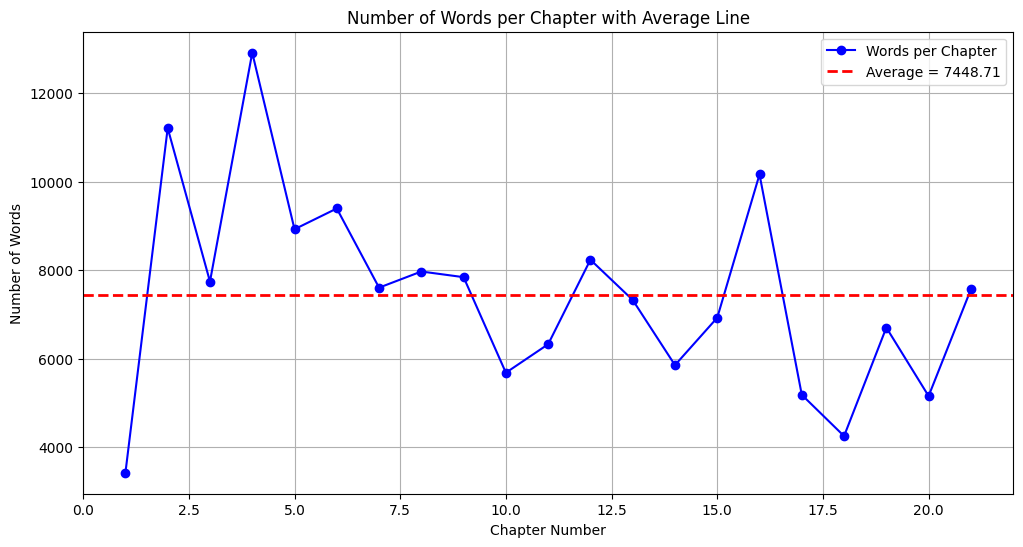

In [ ]:
from pyspark.sql.functions import size, avg
import matplotlib.pyplot as plt

# Create Spark session
spark = SparkSession.builder.appName("Question2").getOrCreate()

# Calculate number of words per chapter
df = df.withColumn("num_words", size(split(col("text"), r"\s+")))

# Calculate average number of words per chapter
avg_length = df.select(avg(col("num_words")).alias("avg_chapter_length")).collect()[0]["avg_chapter_length"]

# Convert to Pandas dataframe for plotting, add chapter index
pandas_df = df.select("num_words").toPandas()
pandas_df['chapter'] = range(1, len(pandas_df) + 1)  # Chapter numbers starting at 1

# Plot number of words per chapter
plt.figure(figsize=(12,6))
plt.plot(pandas_df['chapter'], pandas_df['num_words'], marker='o', linestyle='-', color='blue', label='Words per Chapter')
plt.axhline(avg_length, color='red', linestyle='dashed', linewidth=2, label=f'Average = {avg_length:.2f}')
plt.xlabel("Chapter Number")
plt.ylabel("Number of Words")
plt.title("Number of Words per Chapter with Average Line")
plt.legend()
plt.grid(True)
plt.show()

# **QUERY 3**

+-------+-----+
|   word|count|
+-------+-----+
|    Sam|  392|
| Gollum|  288|
|Aragorn|  195|
|   Orcs|  191|
|Gandalf|  123|
+-------+-----+



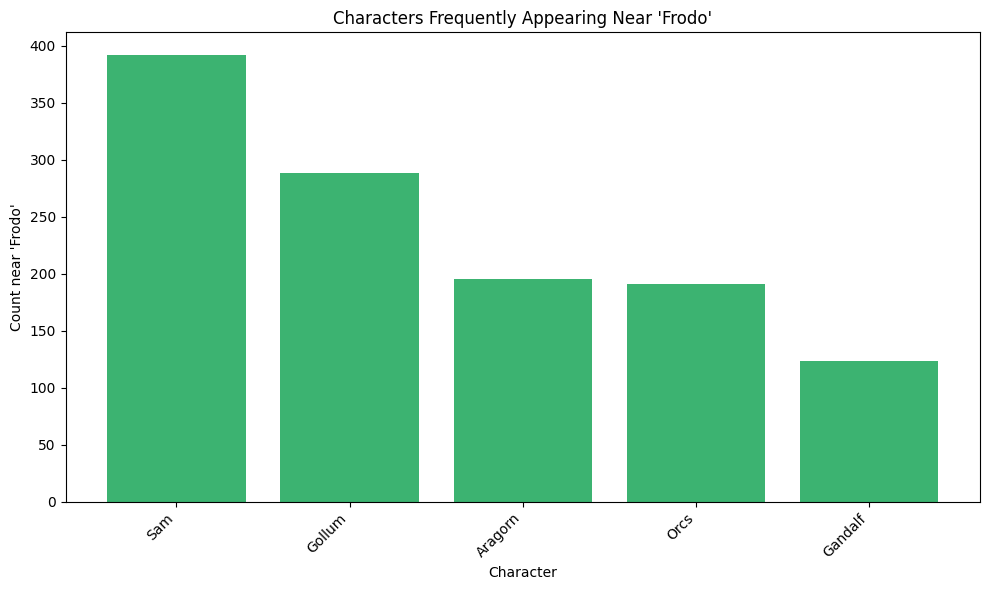

In [ ]:
from pyspark.sql.functions import lower, regexp_replace, split

spark = SparkSession.builder.appName("Question3").getOrCreate()

# List of imporant characters of the question numer 1
important_names = important_characters.select("word").withColumnRenamed("word", "name")

# Chapters that contain the work Frodo
tokens = df.filter(lower(col("text")).contains("frodo")) \
    .select("chapter_id", explode(split(col("text"), r"\s+")).alias("word"))

# Clean punctuation
tokens = tokens.withColumn("word", regexp_replace("word", r"[^\w]", ""))

# Filter only important names
character_near_frodo = tokens.join(
    important_names, tokens.word == important_names.name, "inner"
).filter(col("word") != "Frodo") \
 .groupBy("word").count().orderBy("count", ascending=False)

# Show result
character_near_frodo.show()

# Convert Spark DataFrame to Pandas for plotting
pandas_df = character_near_frodo.toPandas()

# Plot bar chart
plt.figure(figsize=(10,6))
plt.bar(pandas_df['word'], pandas_df['count'], color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Character")
plt.ylabel("Count near 'Frodo'")
plt.title("Characters Frequently Appearing Near 'Frodo'")
plt.tight_layout()
plt.show()


# **QUERY 4**

+----------+--------------------+-----+
|chapter_id|       chapter_title|count|
+----------+--------------------+-----+
|         4|           TREEBEARD|   22|
|         8|THE ROAD TO ISENGARD|   15|
|        21|THE CHOICES OF MA...|   13|
|        15|OF HERBS AND STEW...|   10|
|         9| F LOTSAM AND JETSAM|   10|
|        16|THE WINDOW ON THE...|    9|
|         7|         HELM’S DEEP|    9|
|        11|      THE PALANTÍ R|    8|
|        13|THE PASSAGE OF TH...|    8|
|         2| THE RIDERS OF ROHAN|    7|
|         3|        THE URUK-HAI|    6|
|         6|THE KING OF THE G...|    5|
|        10|THE VOICE OF SARUMAN|    5|
|        20|       SHELOB’S LAIR|    4|
|         5|     THE WHITE RIDER|    3|
|        17|  THE FORBIDDEN POOL|    2|
|        12|THE TAMING OF SME...|    2|
|        19|THE STAIRS OF CIR...|    2|
|        18|JOURNEY TO THE CR...|    2|
|         1|THE DEPARTURE OF ...|    2|
+----------+--------------------+-----+
only showing top 20 rows



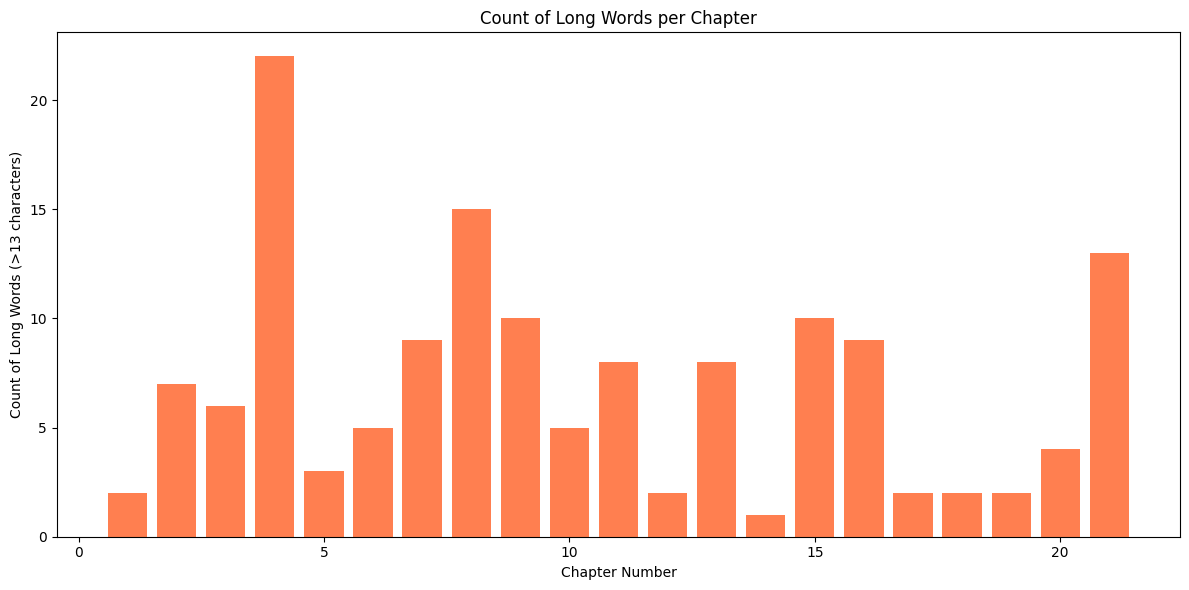

In [ ]:
from pyspark.sql.functions import length
import pandas as pd

spark = SparkSession.builder.appName("Question4").getOrCreate()

# Tokenize the words
tokens = df.select("chapter_id", "chapter_title", explode(split(col("text"), r"\s+")).alias("word"))

# Filters longest words (13 characters)
long_words = tokens.filter(length(col("word")) > 13)

# Count per chapter
long_word_counts = long_words.groupBy("chapter_id", "chapter_title").count().orderBy("count", ascending=False)

# Show result
long_word_counts.show()

# Convert to pandas
pandas_df = long_word_counts.toPandas()

# Convert chapter_id to integer for correct sorting
pandas_df['chapter_id'] = pd.to_numeric(pandas_df['chapter_id'], errors='coerce')

# Drop rows where chapter_id couldn't convert (optional)
pandas_df = pandas_df.dropna(subset=['chapter_id'])

# Sort by chapter_id numerically
pandas_df = pandas_df.sort_values(by='chapter_id')

# Plot
plt.figure(figsize=(12,6))
plt.bar(pandas_df['chapter_id'].astype(int), pandas_df['count'], color='coral')
plt.xlabel("Chapter Number")
plt.ylabel("Count of Long Words (>13 characters)")
plt.title("Count of Long Words per Chapter")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# **QUERY 5**

+-------+-------+-----+
|  char1|  char2|count|
+-------+-------+-----+
|  Frodo|    Sam|   74|
|    Sam| Gollum|   54|
|    Sam|    Sam|   50|
|    Sam|  Frodo|   48|
| Gollum|    Sam|   45|
|Gandalf|Gandalf|   44|
|  Frodo| Gollum|   42|
| Gollum|  Frodo|   41|
|   Orcs|   Orcs|   28|
| Gollum| Gollum|   27|
|  Frodo|  Frodo|   26|
|Aragorn|Gandalf|   15|
|Aragorn|Aragorn|   11|
|Gandalf|Aragorn|    9|
|Aragorn|   Orcs|    9|
|   Orcs|Aragorn|    9|
|  Frodo|Gandalf|    8|
|   Orcs|    Sam|    7|
|Gandalf|   Orcs|    6|
|   Orcs|Gandalf|    5|
+-------+-------+-----+
only showing top 20 rows



<ipython-input-5-db1bc570a245>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pairs['pair'] = top_pairs['char1'] + " - " + top_pairs['char2']


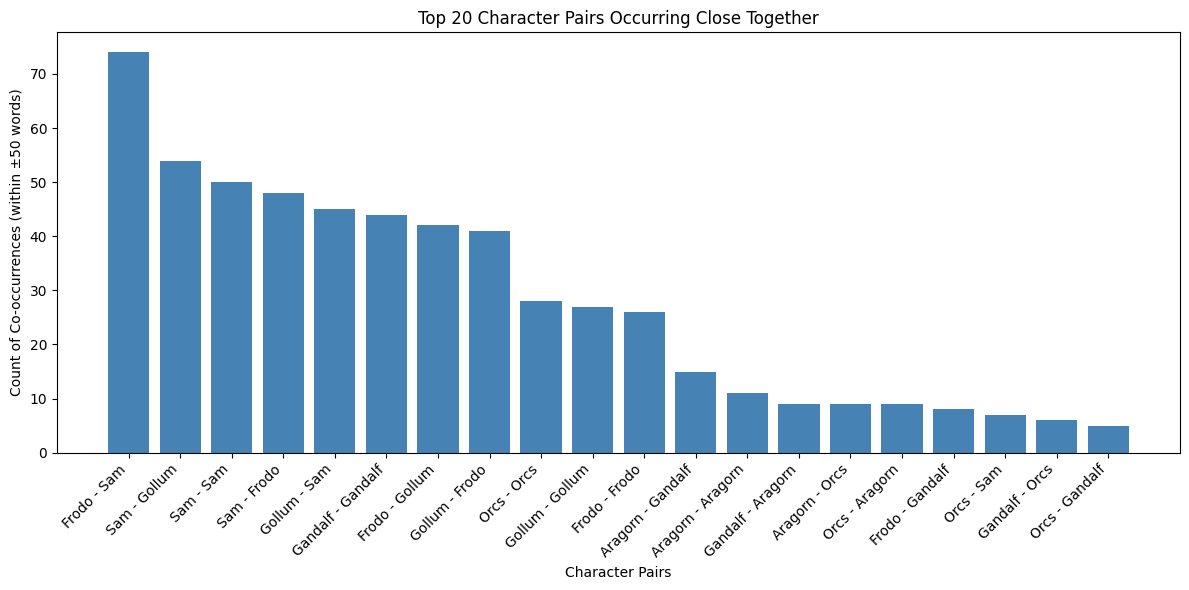

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id


spark = SparkSession.builder.appName("Question5").getOrCreate()


# Tokenize each word for posistion
tokenized = df.select("chapter_id", explode(split(col("text"), r"\s+")).alias("word")) \
              .withColumn("pos", monotonically_increasing_id())

# Filter only important names
named_tokens = tokenized.join(
    important_characters.withColumnRenamed("word", "name"),
    tokenized.word == col("name"),
    "inner"
).select("chapter_id", "word", "pos")

# Self-join in range of ±50 positions inside of the same chapter
pairs = named_tokens.alias("a").join(
    named_tokens.alias("b"),
    (col("a.chapter_id") == col("b.chapter_id")) &
    (col("a.pos") < col("b.pos")) &
    ((col("b.pos") - col("a.pos")) <= 50)
)

# Create pairs
character_pairs_window = pairs.select(
    col("a.word").alias("char1"),
    col("b.word").alias("char2")
).groupBy("char1", "char2").count().orderBy("count", ascending=False)

# Show
character_pairs_window.show()

# Convert Spark DataFrame to Pandas
pandas_df = character_pairs_window.toPandas()

# Optional: Select top N pairs to plot (e.g., top 20)
top_n = 20
top_pairs = pandas_df.head(top_n)

# Create labels for pairs (e.g., "Frodo - Sam")
top_pairs['pair'] = top_pairs['char1'] + " - " + top_pairs['char2']

# Plot bar chart
plt.figure(figsize=(12,6))
plt.bar(top_pairs['pair'], top_pairs['count'], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Character Pairs")
plt.ylabel("Count of Co-occurrences (within ±50 words)")
plt.title(f"Top {top_n} Character Pairs Occurring Close Together")
plt.tight_layout()
plt.show()
